# Importing libraries

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import warnings
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")


2025-11-10 11:49:58.678050: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762775398.858877      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762775398.913200      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Install randomness to repeat results

In [2]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Download images

In [3]:
def load_images_from_directory(directory, image_size=(128, 128)):
    images = []
    labels = []
    label_map = {'without_mask': 0, 'with_mask': 1}  

    for label_name, label_idx in label_map.items():
        folder_path = os.path.join(directory, label_name)
        for file in os.listdir(folder_path):
            try:
                img = Image.open(os.path.join(folder_path, file)).convert('RGB')
                img = img.resize(image_size)
                img = np.array(img) / 255.0  
                images.append(img)
                labels.append(label_idx)
            except Exception as e:
                print(f"Image skipped due to error: {e}")
                continue

    return np.array(images), to_categorical(labels)

# load data

In [4]:

X, y = load_images_from_directory('/kaggle/input/face-mask-dataset/data')


# Data splitting

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Building CNN model

In [6]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2),         
    Softmax()         
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


I0000 00:00:1762775462.693668      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


# model training

In [7]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=2
)

Epoch 1/10


I0000 00:00:1762775468.973882      97 service.cc:148] XLA service 0x7a933400a050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762775468.974570      97 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1762775469.227838      97 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1762775471.770223      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


170/170 - 10s - 57ms/step - accuracy: 0.8473 - loss: 0.3609 - val_accuracy: 0.8661 - val_loss: 0.3008
Epoch 2/10
170/170 - 2s - 10ms/step - accuracy: 0.9101 - loss: 0.2206 - val_accuracy: 0.8942 - val_loss: 0.2617
Epoch 3/10
170/170 - 2s - 10ms/step - accuracy: 0.9340 - loss: 0.1712 - val_accuracy: 0.8926 - val_loss: 0.2809
Epoch 4/10
170/170 - 2s - 10ms/step - accuracy: 0.9537 - loss: 0.1218 - val_accuracy: 0.8959 - val_loss: 0.2764
Epoch 5/10
170/170 - 2s - 10ms/step - accuracy: 0.9625 - loss: 0.1022 - val_accuracy: 0.9041 - val_loss: 0.3160


# Accuracy and loss comparison

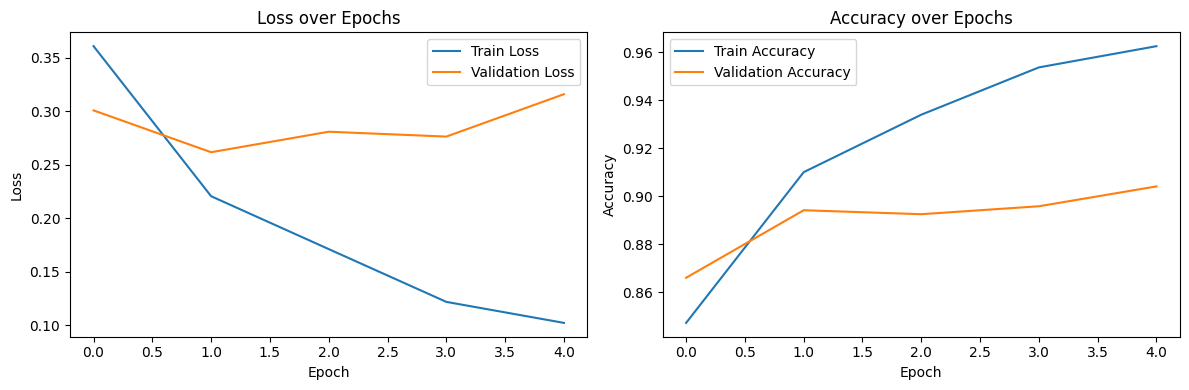

In [8]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Model evaluation

In [9]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f" Test Accuracy: {test_acc*100:.2f}%")
print(f" Test Loss: {test_loss:.4f}")

 Test Accuracy: 90.87%
 Test Loss: 0.2170


# Prediction

In [10]:
labels = ['Without Mask', 'With Mask']

def predict_mask(image_path, model, image_size=(128, 128)):
    try:
        img = Image.open(image_path).convert('RGB')
        img_resized = img.resize(image_size)
        img_array = np.array(img_resized) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        prediction = model.predict(img_array, verbose=0)[0]
        class_index = np.argmax(prediction)
        confidence = prediction[class_index] * 100
        
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Prediction: {labels[class_index]}")
        plt.show()

    except Exception as e:
        print(f"Prediction error: {e}")

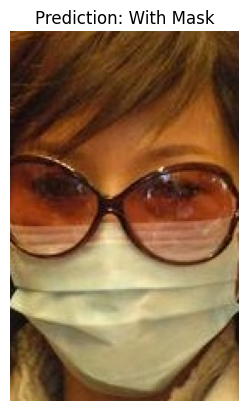

In [17]:
predict_mask('/kaggle/input/face-mask-dataset/data/with_mask/with_mask_10.jpg', model)

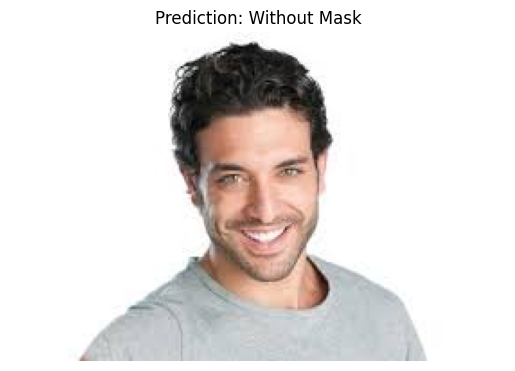

In [12]:
predict_mask('/kaggle/input/face-mask-dataset/data/without_mask/without_mask_1000.jpg', model)